In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import numpy as np

In [5]:
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm

In [6]:
from scipy.stats import kde

In [7]:
from tqdm import tqdm_notebook

## синтезирую задачу

In [8]:
x_class1 = np.random.randn(1000, 2)*np.array([2, 3])+np.array([5, 5])

In [9]:
x_class0 = np.random.randn(1000, 2)*np.array([3, 2])-np.array([2, 2])

In [10]:
y = np.squeeze(np.concatenate([np.zeros((1000,1), dtype=int), np.ones((1000,1), dtype=int)], axis=0))

In [11]:
x = np.concatenate([x_class0, x_class1], axis=0)
x.shape

(2000, 2)

In [12]:
nbins=300

In [13]:
xmesh, ymesh = np.mgrid[-10:10:nbins*1j, -10:10:nbins*1j]

In [14]:
k_class0 = kde.gaussian_kde(x_class0.T)
dens_class0 = k_class0(np.vstack([xmesh.flatten(), ymesh.flatten()]))

In [15]:
k_class1 = kde.gaussian_kde(x_class1.T)
dens_class1 = k_class1(np.vstack([xmesh.flatten(), ymesh.flatten()]))

<Figure size 1800x1200 with 0 Axes>

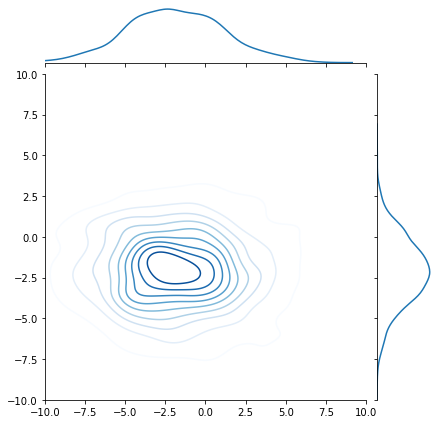

In [16]:
f = plt.figure(figsize=(6,4), dpi=300)
p = sns.jointplot(x=x_class0[:,0], y=x_class0[:,1], kind='kde', cmap='Blues')
_ = p.ax_marg_x.set_xlim(-10, 10)
_ = p.ax_marg_y.set_ylim(-10, 10)
# f.patch.set_facecolor('white')

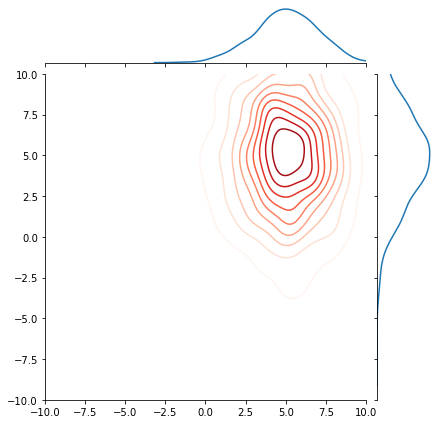

In [17]:
p = sns.jointplot(x=x_class1[:,0], y=x_class1[:,1], kind='kde', cmap='Reds')
_ = p.ax_marg_x.set_xlim(-10, 10)
_ = p.ax_marg_y.set_ylim(-10, 10)

## Цель:
## $P(Y=k|X=x_i)$ - ?

## отображение исходных данных

/var/folders/92/5svctq411yj8fbmd93p7z89w0000gn/T/ipykernel_20280/2012307714.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  _ = plt.pcolormesh(xmesh, ymesh, (dens_class1-dens_class0).reshape(xmesh.shape), cmap='seismic')


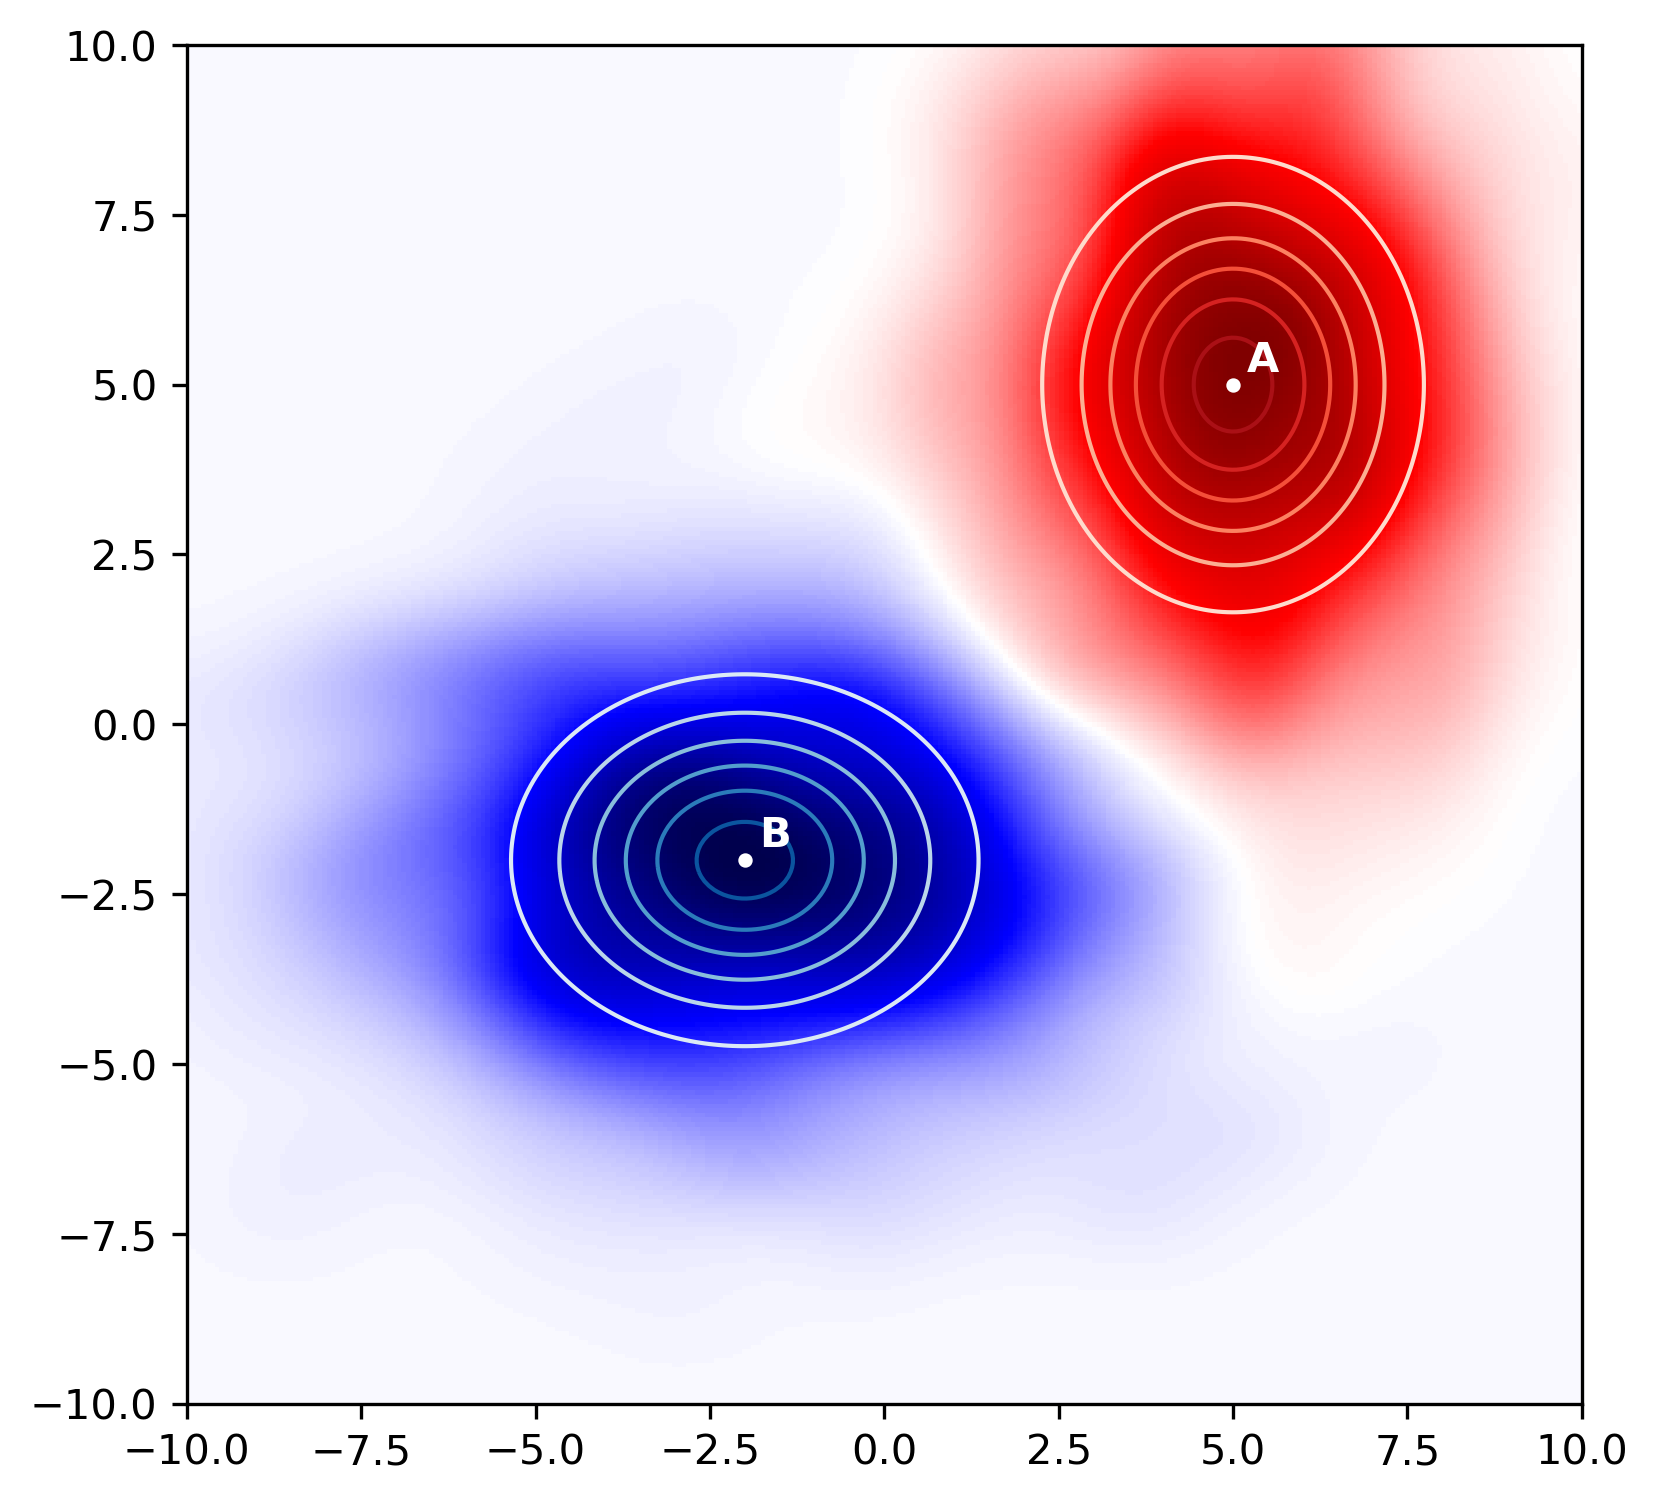

In [18]:
_ = plt.figure(figsize=(6,6), dpi=300)

rv = mnorm([5, 5], [[2.0, 0.0], [0.0, 3.0]])
norm_class1 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))
rv = mnorm([-2, -2], [[3.0, 0.0], [0.0, 2.0]])
norm_class0 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))
_ = plt.pcolormesh(xmesh, ymesh, (dens_class1-dens_class0).reshape(xmesh.shape), cmap='seismic')
_ = plt.contour(xmesh, ymesh, norm_class1, cmap='Reds', linewidths=1)
_ = plt.scatter([5], [5], s=6, c='white')
_ = plt.text(5.2,5.2,'A', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, norm_class0, cmap='Blues', linewidths=1)
_ = plt.scatter([-2], [-2], s=6, c='white')
_ = plt.text(-1.8, -1.8, 'B', color='white', fontweight='bold')
_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)

## Naïve bayes своими руками

In [22]:
def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices], X[oob_indices, :], y[oob_indices]
    else:
        return X[sample_indices, :], y[sample_indices]

In [19]:
class naive_bayes:
    def __init__(self):
        self.mu = None
        self.sigmasq = None
        self.p_y = None
        self.classes = None
    
    def fit(self, X, y):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (y.ndim == 1), "y should be 2-dimensional: (N of objects, one column)"
        
        self.classes = np.squeeze(np.unique(y))
        self.mu = {}
        for k in self.classes:
            self.mu[k] = np.mean(X[y==k], axis=0)
        self.sigmasq = {}
        for k in self.classes:
            self.sigmasq[k] = np.var(X[y==k], axis=0)
        self.p_y = {}
        for k in self.classes:
            self.p_y[k] = np.mean(y==k)
    
    def predict(self, X, return_proba = False):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert ((self.mu is not None)
                and (self.sigmasq is not None)
                and (self.p_y is not None)
                and (self.classes is not None)), "parameters are None. perhaps, you should fit the model first."
        
        p_x_given_y = np.zeros((X.shape[0], X.shape[1], len(self.classes)))
        for feature_idx in range(X.shape[1]):
            for k in self.classes:
                p_x_given_y[:, feature_idx, k] = norm.pdf(X[:, feature_idx],
                                                          loc=self.mu[k][feature_idx],
                                                          scale=np.sqrt(self.sigmasq[k][feature_idx]))
        
        p_x_given_y_prod = np.prod(p_x_given_y, axis=1)
        p_y_given_x = p_x_given_y_prod * np.array([self.p_y[k] for k in self.classes])
        p_y_given_x_normed = p_y_given_x / p_y_given_x.sum(axis=1)[:,np.newaxis]
        y_pred = (p_y_given_x_normed[:,1]>=p_y_given_x_normed[:,0]).astype(int)
        
        if return_proba:
            return y_pred, p_y_given_x_normed
        else:
            return y_pred

In [20]:
B = 2000

In [23]:
sample_size = x.shape[0]
acc = []
for i in tqdm_notebook(range(B), total=B):
    Xtrain,ytrain,Xoob,yoob = sample_bootstrap(x,y, sample_size=sample_size, return_OOB_sample=True)
    nbmodel = naive_bayes()
    nbmodel.fit(Xtrain, ytrain)
    yoob_pred,yoob_proba = nbmodel.predict(Xoob, return_proba=True)
    acc.append(np.mean(yoob_pred==yoob))

/var/folders/92/5svctq411yj8fbmd93p7z89w0000gn/T/ipykernel_20280/24785354.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(B), total=B):


  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
acc = np.array(acc)

In [25]:
acc.mean()

0.9702273939838747

In [26]:
acc.std()

0.0051030948145498545

In [27]:
B = 2000
sample_size = x.shape[0]
Xtrain,ytrain,Xoob,yoob = sample_bootstrap(x,y, sample_size=sample_size, return_OOB_sample=True)
nbmodel = naive_bayes()
nbmodel.fit(Xtrain, ytrain)
yoob_pred,yoob_proba = nbmodel.predict(Xoob, return_proba=True)

## то же самое, но с использованием sklearn

##### Просто чтобы удостовериться, что наш код работает так же, как у остальных $N$ тысяч специалистов, которые не утруждаются реализовать модель Naive Bayes самостоятельно

In [29]:
from sklearn.naive_bayes import GaussianNB

In [30]:
gnb = GaussianNB()

In [31]:
gnb.fit(Xtrain, ytrain)

GaussianNB()

In [32]:
yoob_pred_sk = gnb.predict(Xoob)
yoob_proba_sk = gnb.predict_proba(Xoob)

##### сверим результаты

In [33]:
np.mean(yoob_pred == yoob_pred_sk)

1.0

## voilà ↑

## отобразим вероятности в пространстве признаков

In [34]:
x_test_mesh = np.concatenate([xmesh.ravel()[:,np.newaxis], ymesh.ravel()[:,np.newaxis]], axis=-1)
x_test_mesh.shape

(90000, 2)

In [35]:
preds_mesh,probas_mesh = nbmodel.predict(x_test_mesh, return_proba=True)

In [36]:
probas_mesh_class0 = probas_mesh[:,0].reshape(xmesh.shape)
probas_mesh_class1 = probas_mesh[:,1].reshape(xmesh.shape)

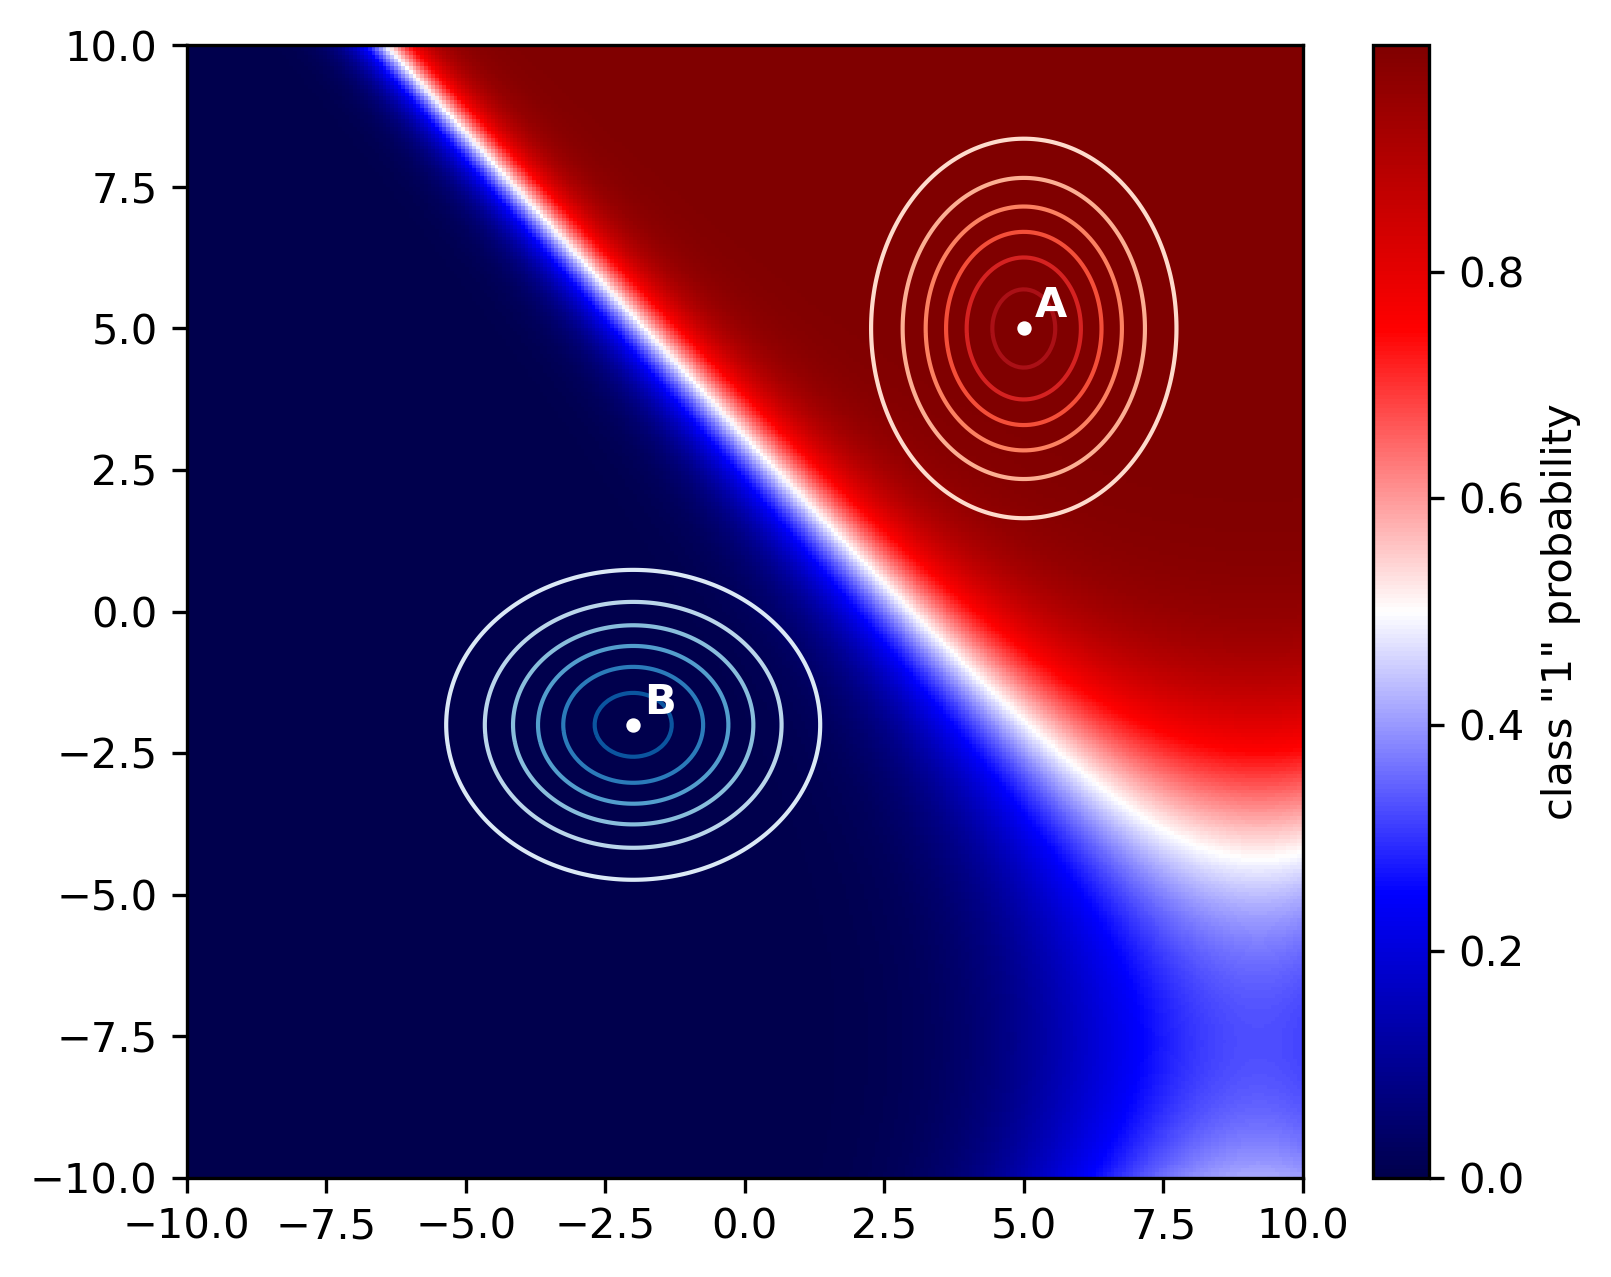

In [37]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)
_ = plt.pcolormesh(xmesh, ymesh, (1+probas_mesh_class1-probas_mesh_class0)/2, cmap='seismic', shading='auto')
cb = plt.colorbar()
cb.set_label('class "1" probability')
_ = plt.contour(xmesh, ymesh, norm_class1, cmap='Reds', linewidths=1)
_ = plt.scatter([5], [5], s=6, c='white')
_ = plt.text(5.2,5.2,'A', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, norm_class0, cmap='Blues', linewidths=1)
_ = plt.scatter([-2], [-2], s=6, c='white')
_ = plt.text(-1.8, -1.8, 'B', color='white', fontweight='bold')

## посмотрим на то, как выглядит вероятность классов в разрезе AB

In [38]:
p0 = np.array([-2, -2])
p1 = np.array([5, 5])
linspace = np.array([p0+k*((p1-p0)/100) for k in np.linspace(-50, 150, 500)])
linspace.shape

(500, 2)

In [39]:
preds_linspace,probas_linspace = nbmodel.predict(linspace, return_proba=True)

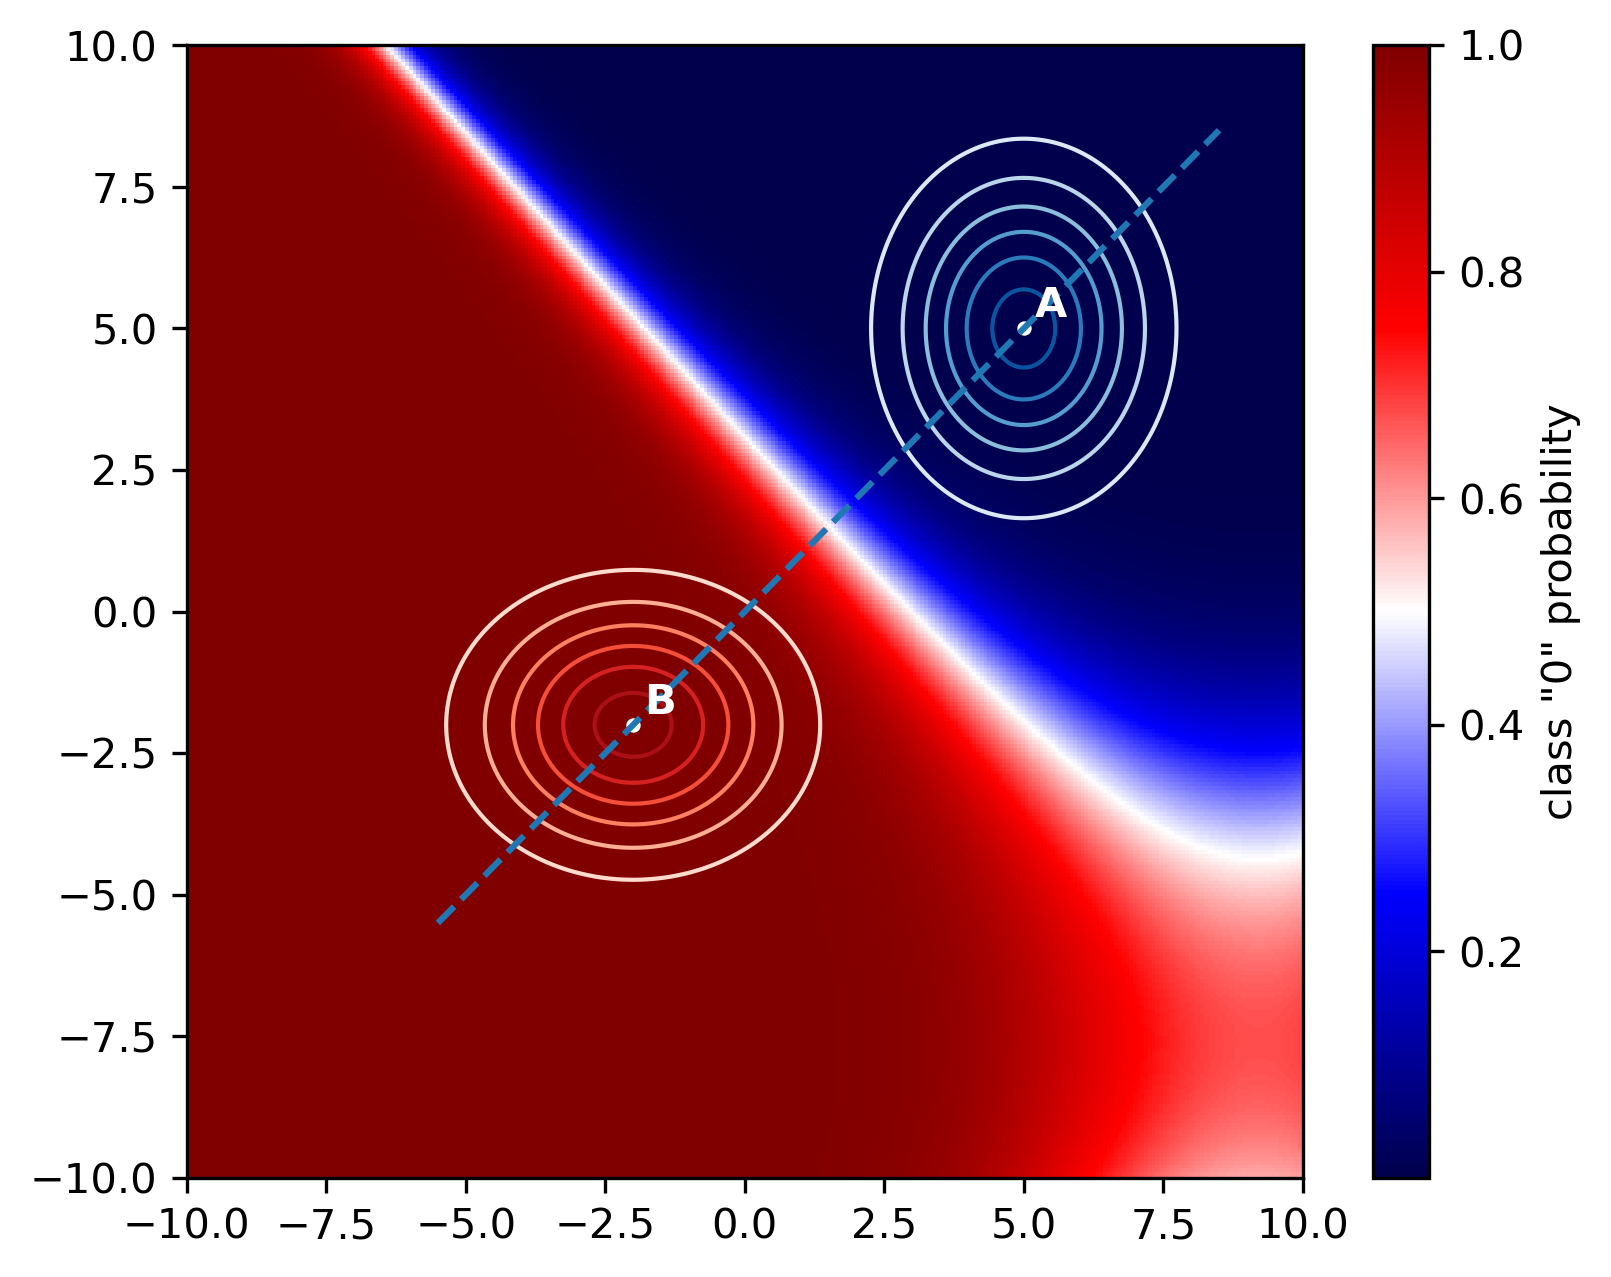

In [40]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)
_ = plt.pcolormesh(xmesh, ymesh, (1+probas_mesh_class0-probas_mesh_class1)/2, cmap='seismic', shading='auto')
cb = plt.colorbar()
cb.set_label('class "0" probability')
_ = plt.contour(xmesh, ymesh, norm_class0, cmap='Reds', linewidths=1)
_ = plt.scatter([5], [5], s=6, c='white')
_ = plt.text(5.2,5.2,'A', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, norm_class1, cmap='Blues', linewidths=1)
_ = plt.scatter([-2], [-2], s=6, c='white')
_ = plt.text(-1.8, -1.8, 'B', color='white', fontweight='bold')
_ = plt.plot(linspace[:,0], linspace[:,1], '--')

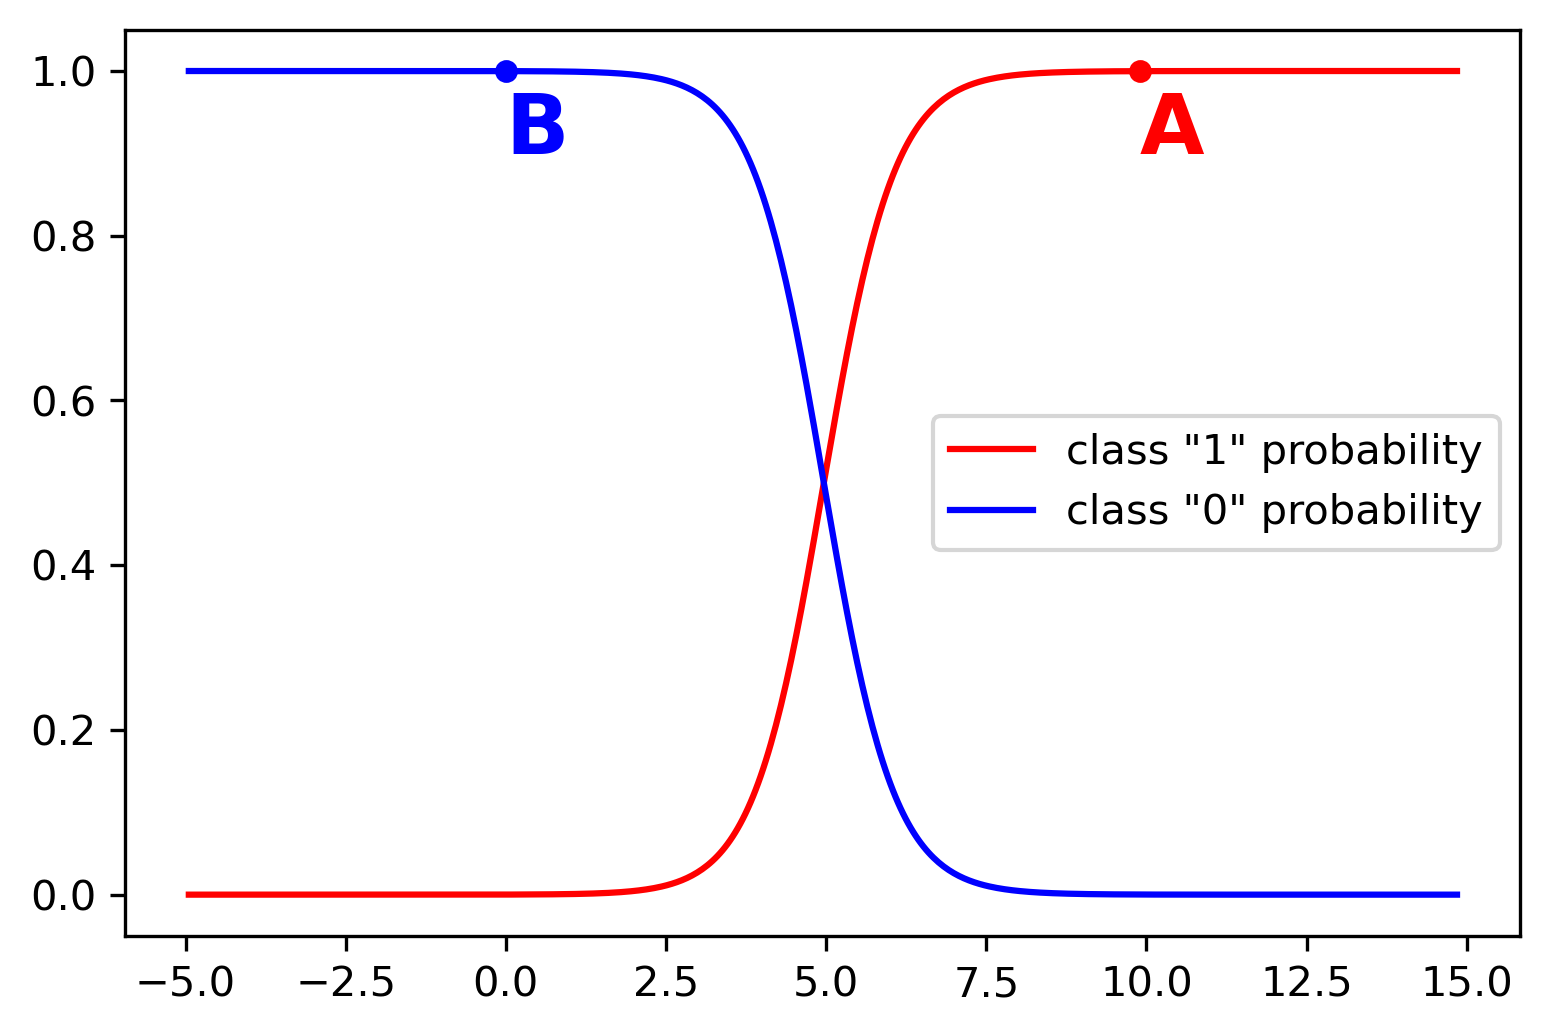

In [41]:
_ = plt.figure(figsize=(6,4), dpi=300)
_ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
             probas_linspace[:,1],
             color='red',
             label='class "1" probability')
_ = plt.scatter([np.linalg.norm(p1-p0)], [1.0], s=20, color='red')
_ = plt.text(np.linalg.norm(p1-p0), 0.9, 'A', color='red', fontweight='bold', fontsize=20)
_ = plt.scatter([0.0], [1.0], s=20, color='blue')
_ = plt.text(0, 0.9, 'B', color='blue', fontweight='bold', fontsize=20)
_ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
             probas_linspace[:,0],
             color='blue',
             label='class "0" probability')
plt.legend()

## Разделяющая поверхность

In [43]:
p_th = 0.5

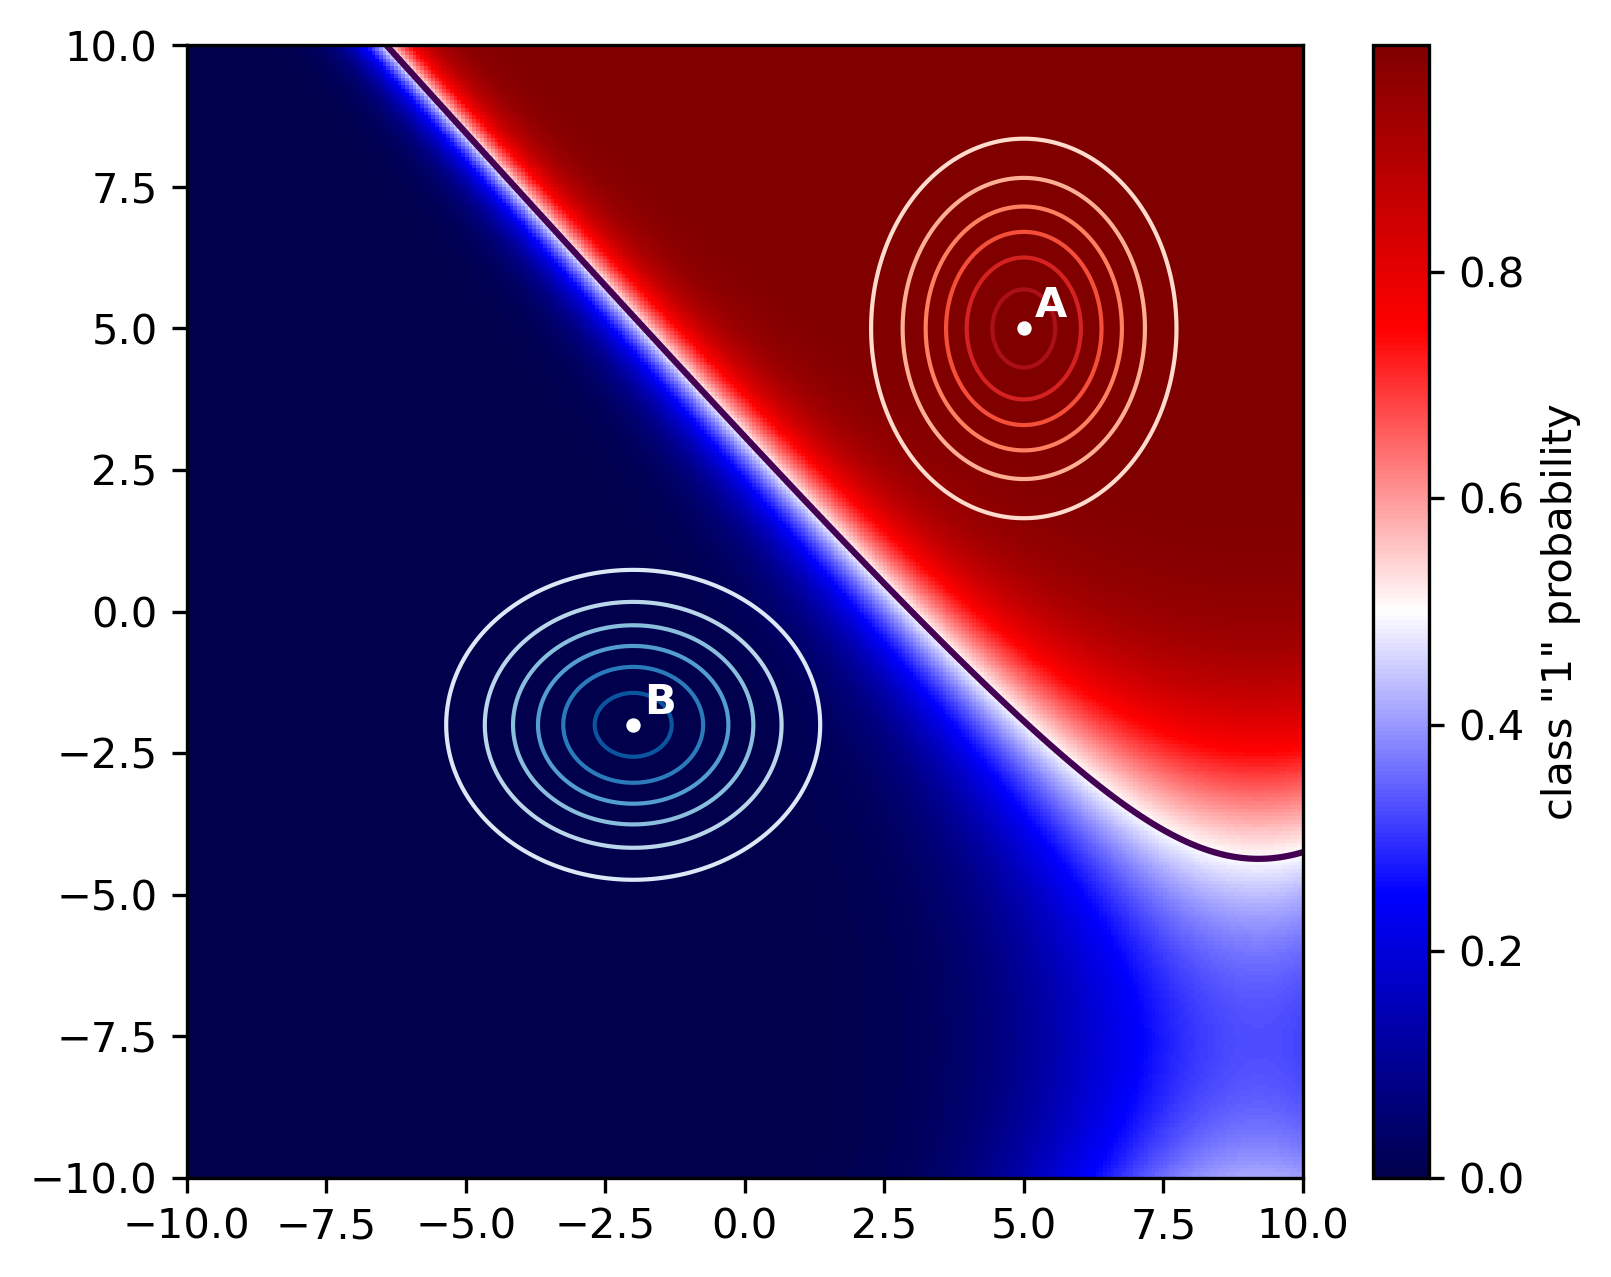

In [44]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)
_ = plt.pcolormesh(xmesh, ymesh, (1+probas_mesh_class1-probas_mesh_class0)/2, cmap='seismic', shading='auto')
cb = plt.colorbar()
cb.set_label('class "1" probability')
_ = plt.contour(xmesh, ymesh, norm_class0, cmap='Blues', linewidths=1)
_ = plt.scatter([5], [5], s=6, c='white')
_ = plt.text(5.2,5.2,'A', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, norm_class1, cmap='Reds', linewidths=1)
_ = plt.scatter([-2], [-2], s=6, c='white')
_ = plt.text(-1.8, -1.8, 'B', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, probas_mesh_class0, levels=[0.5])